In [1]:
import os
import sys
import datacube
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from odc.ui import with_ui_cbk
from datacube.utils import masking
import matplotlib.dates as mdates
import time

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr

#sys.path.append('../dea-notebooks/Scripts/')
#from dea_spatialtools import xr_vectorize, xr_rasterize
from datacube.utils import geometry as geom
sys.path.append('../dea-notebooks/Scripts/')
import dea_datahandling
from datacube.model import Measurement
from datacube.utils import unsqueeze_dataset

#sys.path.append('../')
os.chdir('../fc')
from fc.fractional_cover import fractional_cover 

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35301")
client

Client Scheduler: tcp://127.0.0.1:35301 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 16.11 GB


In [3]:
def load_L578_fc(date_init, date_end, ul_coord, lr_coord, crs, dask_chunks):
    lat_north = ul_coord[0] 
    lat_south = lr_coord[0]
    lon_west  = ul_coord[1]
    lon_east  = lr_coord[1]

    dc = datacube.Datacube(app="L578_FC")
    #dask_chunks = {"time": 100, "x": -1, "y": -1}
    
    #Define temporal range
    start_of_epoch = date_init
    end_of_epoch   =  date_end
    
    query = {
        "time": (start_of_epoch, end_of_epoch),
        "x": (lon_west,lon_east),
        "y": (lat_north, lat_south),
        "product": ["ga_ls_fc_3"], 
        "measurements":["bs", "pv", "npv"],
        "resolution": (-30, 30),
        "crs": crs,
        "output_crs": crs,
        "group_by": "solar_day",
        "dask_chunks": dask_chunks
    }

    L578_fc =  dc.load( **query) 

    return L578_fc


def load_fc_mask(date_init, date_end, ul_coord, lr_coord, crs, dask_chunks):
    lat_north = ul_coord[0] 
    lat_south = lr_coord[0]
    lon_west  = ul_coord[1]
    lon_east  = lr_coord[1]

    dc = datacube.Datacube(app="L578_FC")
    #dask_chunks = {"time": 100, "x": -1, "y": -1}
        
    query = {
        "time": (date_init, date_end),
        "x": (lon_west,lon_east),
        "y": (lat_north, lat_south),
        "product": ["ga_ls_fc_3"], 
        "measurements":["bs", "pv", "npv"],
        "resolution": (-30, 30),
        "crs": crs,
        "output_crs": crs,
        "group_by": "solar_day",
        "dask_chunks": dask_chunks
    }

    L578_fc =  dc.load( **query) 
    
    wofl = dc.load(product="ga_ls_wo_3", group_by="solar_day", like=L578_fc, dask_chunks = dask_chunks) #, progress_cbk=with_ui_cbk())
    clear = {"cloud_shadow": False, "cloud": False} #, "dry":True}
    cloudfree = masking.make_mask(wofl, **clear)
    clean_L578_fc = L578_fc.where((cloudfree.water == True) & (L578_fc < 255))
    del L578_fc  # don't need this anymore, clear memory 
    clean_L578_fc['totcov'] = clean_L578_fc['pv']+clean_L578_fc['npv']

    # convert time to Australia Sydney 
    #clean_L578_fc['time'] = clean_L578_fc.indexes['time'].tz_localize('UTC').tz_convert('Australia/Sydney').tz_localize(None)

    # get rid of the time from the date (I don't need it)
    #clean_L578_fc['time'] = clean_L578_fc.indexes['time'].normalize()

    #clean_L578_fc_uint8.time.encoding['units'] = "Seconds since 1970-01-01 00:00:00"  
    #clean_L578_fc.round().fillna(255).astype('uint8').to_netcdf(fname)

    return clean_L578_fc


def load_s2_reflectance(date_init, date_end, ul_coord, lr_coord, crs, dask_chunks):
    lat_north = ul_coord[0] 
    lat_south = lr_coord[0]
    lon_west  = ul_coord[1]
    lon_east  = lr_coord[1]

    dc = datacube.Datacube()
    
    query = {
        "time": (date_init, date_end),
        "x": (lon_west,lon_east),
        "y": (lat_north, lat_south),
        "products": ["s2a_ard_granule", "s2b_ard_granule"], 
        "measurements":[#"nbart_blue", 
                        "nbart_green", 
                        "nbart_red", 
                        #"nbart_red_edge_1", 
                        #"nbart_red_edge_2", 
                        #"nbart_red_edge_3", 
                        "nbart_nir_1", 
                        #"nbart_nir_2", 
                        "nbart_swir_2", 
                        "nbart_swir_3"],
        "resolution": (-30, 30),
        "crs": crs,        
        "output_crs": "EPSG:3577",
        "dask_chunks": dask_chunks,
        "min_gooddata": 0.0, 
        "group_by": "solar_day"
    }
    print(query)
    ds = dea_datahandling.load_ard(dc=dc,  **query) # progress_cbk=with_ui_cbk()
    return ds

def load_L578_reflectance(date_init, date_end, ul_coord, lr_coord, crs, dask_chunks, product):
    lat_north = ul_coord[0] 
    lat_south = lr_coord[0]
    lon_west  = ul_coord[1]
    lon_east  = lr_coord[1]

    dc = datacube.Datacube()
 
    if product == 'L8':
        products = ['ga_ls8c_ard_3']
    if product == 'L57':
        products = ['ga_ls5t_ard_3','ga_ls7e_ard_3']
    
    query = {
        "time": (date_init, date_end),
        "x": (lon_west,lon_east),
        "y": (lat_north, lat_south),
        "products": products,
        
        "measurements": [#"nbart_blue", 
                         "nbart_green", 
                         "nbart_red", 
                         "nbart_nir", 
                         "nbart_swir_1", 
                         "nbart_swir_2"],
        "resolution": (-30, 30),
    #    'mask_pixel_quality': False,
        "crs": crs,
        "output_crs": "EPSG:3577",
        
        "dask_chunks": dask_chunks,
    #    'min_gooddata':0.75, 
         "min_gooddata": 0.0, 
         "group_by": "solar_day"
    }
    #print(query)

    start = time.process_time()
    ds = dea_datahandling.load_ard(dc=dc, progress_cbk=with_ui_cbk(), **query)
    print(time.process_time() - start, ' seconds for load_L578_reflectance')

    return ds


def L8toL57(ds):
    """
    Apply regression coefficients in the form: ETM = c0 + OLI*c1
    As per table 2 in http://www.mdpi.com/2072-4292/6/9/7952/htm
    :param numpyarray: array of measurements to apply coefficients to
    :param band: name of the coefficient pair to apply
    :return: updated array
    """    
    
    # adapted from https://github.com/GeoscienceAustralia/fc/blob/master/fc/fractional_cover.py#L177 
    
    ds['nbart_green'] = ds['nbart_green'] * 0.99779 + 0.00289 * 10000
    ds['nbart_red'] = ds['nbart_red'] * 1.00446 + 0.00274 * 10000
    ds['nbart_nir'] = ds['nbart_nir'] * 0.98906 + 0.00004 * 10000
    ds['nbart_swir_1'] = ds['nbart_swir_1'] * 0.99467 + 0.00256 * 10000
    ds['nbart_swir_2'] = ds['nbart_swir_2'] * 1.02551 - 0.00327 * 10000
    
    #make sure thare aren't any negative values (it happens sometimes)
    #ds = np.maximum(0, ds)
    ds = ds.where(ds >= 0)
    
    return ds

def S2toL57(ds):
    """
    Apply regression coefficients in the form: ETM = c0 + S2*c1
    As per table 4 in www.doi.org/10.3390/rs9070659 
    Table 4. Coefficients for Equation (1), to adjust Sentinel-2A reflectance to the corresponding Landsat reflectance. Fitted from the training data described in Table 3.
    Coefficient	Blue	Green	Red	NIR	SWIR1	SWIR2
    Landsat-7	 c0 	−0.0022	0.0031	0.0064	0.012	0.0079	−0.0042
    c1 	0.9551	1.0582	0.9871	1.0187	0.9528	0.9688
    Landsat-8	 c0 	−0.0012	0.0013	0.0027	0.0147	0.0025	−0.0011
    c1 	0.963	1.0473	0.9895	1.0129	0.9626	0.9392    

    """    
        
    ds['nbart_green'] = ds['nbart_green'] * 1.0582 + 0.0031 * 10000
    ds['nbart_red'] = ds['nbart_red'] * 0.9871 + 0.0064 * 10000
    ds['nbart_nir_1'] = ds['nbart_nir_1'] * 1.0187 + 0.012 * 10000
    ds['nbart_swir_2'] = ds['nbart_swir_2'] * 0.9528 + 0.0079 * 10000
    ds['nbart_swir_3'] = ds['nbart_swir_3'] * 0.9688 - 0.0042 * 10000
    
    #make sure thare aren't any negative values (it happens sometimes)
    #ds = np.maximum(0, ds)
    #ds = ds.where(ds >= 0)

    return ds

def rename_bands_L578(ds):
    ds = ds.rename({ #'nbart_blue':   'blue',
                     'nbart_green':  'green',
                     'nbart_red':    'red',
                     'nbart_nir':    'nir',
                     'nbart_swir_1': 'swir1',
                     'nbart_swir_2': 'swir2'})
    return ds

def rename_bands_S2(ds):
    ds = ds.rename({ #'nbart_blue':   'blue',
                     'nbart_green':  'green',
                     'nbart_red':    'red',
                     'nbart_nir_1':    'nir',
                     'nbart_swir_2': 'swir1',
                     'nbart_swir_3': 'swir2'})
    return ds

## Load Landsat 7 and 8, correct L8 reflectance and put it all in an xarray

In [7]:
L57=[]
L8=[]
L578=[]
L578_r=[]

#date_init = '2020-12-24'
#date_end = '2020-12-25'
date_init = '2020-07-17'
date_end = '2020-07-17'
 
    
lon,lat = (150.13882, -29.47906)
buffer=5000
dst_crs = 'epsg:3577'
x, y = geom.point(lon, lat, geom.CRS('epsg:4326')).to_crs(geom.CRS(dst_crs)).coords[0]
ul_coord = [y+buffer, x-buffer]
lr_coord = [y-buffer, x+buffer]
dask_chunks={"time": 5, "x": -1, "y": -1}

try:
    L57 = load_L578_reflectance(date_init, date_end, ul_coord, lr_coord, dst_crs, dask_chunks, 'L57') 
    L578.append(L57)
except:
    print('no L57 data')

try:
    L8 = load_L578_reflectance(date_init, date_end, ul_coord, lr_coord, dst_crs, dask_chunks, 'L8') 
    # apply Neil Flood's linear correction
    L8 = L8toL57(L8)
    L578.append(L8)
except:
    print('no L8 data')

L578_r = xr.concat(L578, dim='time').sortby('time')
L578_r = L578_r.compute()
L578_r

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
no L57 data


/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Finding datasets
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 1 time steps as a dask array
0.11514306799999918  seconds for load_L578_reflectance


<xarray.Dataset>
Dimensions:       (time: 1, x: 334, y: 334)
Coordinates:
  * time          (time) datetime64[ns] 2020-07-17T23:54:46.058368
  * y             (y) float64 -3.323e+06 -3.323e+06 ... -3.333e+06 -3.333e+06
  * x             (x) float64 1.728e+06 1.728e+06 ... 1.738e+06 1.738e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) float32 746.31104 773.25134 ... 435.9983
    nbart_red     (time, y, x) float32 975.6102 999.7173 ... 704.40607 600.94666
    nbart_nir     (time, y, x) float32 1383.1058 1416.7339 ... 1235.736
    nbart_swir_1  (time, y, x) float32 2416.7866 2453.5896 ... 2768.9 2363.0745
    nbart_swir_2  (time, y, x) float32 2217.2688 2277.774 ... 1868.5955
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Load S2, and apply Neil Flood's correction  


In [8]:
date_init = '2020-07-18'
date_end = '2020-07-18'

S2 = load_s2_reflectance(date_init, date_end, ul_coord, lr_coord, dst_crs, dask_chunks) 
S2 = S2.compute()
S2_likeL578 = S2toL57(S2)
S2

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


{'time': ('2020-07-18', '2020-07-18'), 'x': (1728033.4820457108, 1738033.4820457108), 'y': (-3323146.263923362, -3333146.263923362), 'products': ['s2a_ard_granule', 's2b_ard_granule'], 'measurements': ['nbart_green', 'nbart_red', 'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3'], 'resolution': (-30, 30), 'crs': 'epsg:3577', 'output_crs': 'EPSG:3577', 'dask_chunks': {'time': 5, 'x': -1, 'y': -1}, 'min_gooddata': 0.0, 'group_by': 'solar_day'}
Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Applying pixel quality/cloud mask
Returning 1 time steps as a dask array


<xarray.Dataset>
Dimensions:       (time: 1, x: 334, y: 334)
Coordinates:
  * time          (time) datetime64[ns] 2020-07-18T00:05:03.680019
  * y             (y) float64 -3.323e+06 -3.323e+06 ... -3.333e+06 -3.333e+06
  * x             (x) float64 1.728e+06 1.728e+06 ... 1.738e+06 1.738e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) float32 773.8564 767.5072 ... 665.92 713.539
    nbart_red     (time, y, x) float32 999.7708 1002.7321 ... 995.8224 1036.2935
    nbart_nir_1   (time, y, x) float32 1513.5817 1493.2076 ... 1879.2949
    nbart_swir_2  (time, y, x) float32 2392.3984 2462.9055 ... 2192.3103
    nbart_swir_3  (time, y, x) float32 2131.0183 2203.6785 ... 1600.116
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### show me how they look

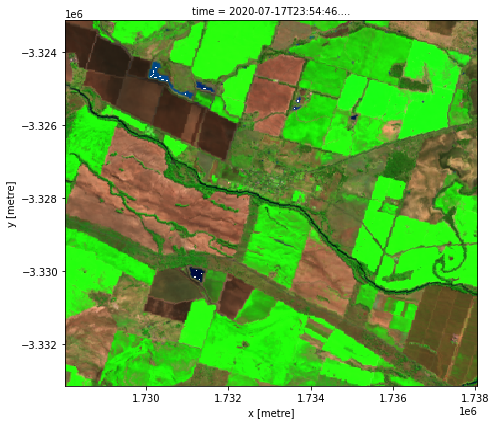

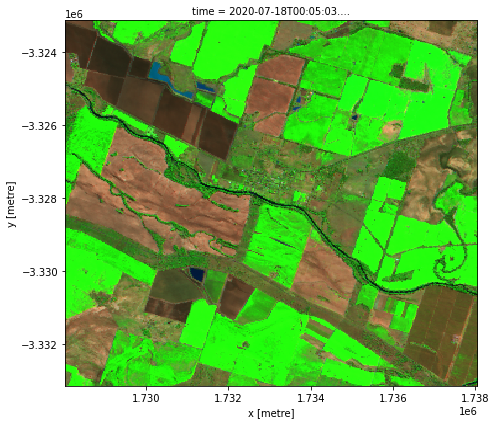

In [9]:
L578_r[['nbart_swir_2', 'nbart_nir', 'nbart_red']].to_array().plot.imshow(col='time', vmin=0, vmax=5000, size=6)
plt.savefig('../fc_juan/'+date_init+'_L578_false_color.png')
plt.show()
#S2[['nbart_swir_3', 'nbart_nir_1', 'nbart_red']].to_array().plot.imshow(col='time', col_wrap=5, vmin=0, vmax=5000, size=6)
S2_likeL578[['nbart_swir_3', 'nbart_nir_1', 'nbart_red']].to_array().plot.imshow(col='time', vmin=0, vmax=5000, size=6)
plt.savefig('../fc_juan/'+date_init+'_S2_false_color.png')
plt.show()


## scatterplots of the reflectance L578 and S2

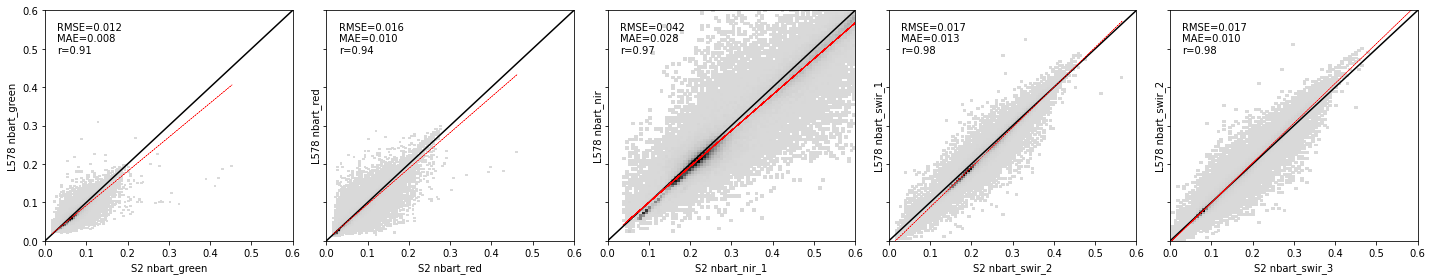

In [10]:
viridis_big = cm.get_cmap('Greys', 256)
newcmp = ListedColormap(viridis_big(np.linspace(0.25, 1.0, 256)))
#plot_examples([viridis, newcmp])


fig, axes = plt.subplots(1,5, figsize=(20,4), tight_layout=True, sharey=True, sharex=True) 
band_L578 = ['nbart_green','nbart_red','nbart_nir','nbart_swir_1','nbart_swir_2']
band_S2   = ['nbart_green','nbart_red','nbart_nir_1','nbart_swir_2','nbart_swir_3']
for f in [0,1,2,3,4]:
    x=S2_likeL578[band_S2[f]].values.ravel() * .0001
    y=L578_r[band_L578[f]].values.ravel() * .0001
    
    # need to remove nans as hist2d doesn't like them
    good_data = np.logical_and(~np.isnan(x), ~np.isnan(y))
    x=x[good_data]
    y=y[good_data]
    
    axes[f].hist2d(x, y, bins=100, cmap=newcmp, cmin=1)
        
    axes[f].plot([0,1], [0,1], color='k')
    axes[f].set_xlim(0,0.6)
    axes[f].set_ylim(0,0.6)
    axes[f].set_ylabel('L578 '+band_L578[f])
    axes[f].set_xlabel('S2 '+band_S2[f])

    m, b = np.polyfit(x, y, 1)
    axes[f].plot(x, m*x + b, linestyle='dashed', color='r', linewidth=0.5)
    
    rmse = np.sqrt(mean_squared_error(x,y))
    mae  = mean_absolute_error(x,y)
    r= pearsonr(x,y)[0]
    text = 'RMSE='+str(format(rmse,'.3f'))+ '\n' +'MAE='+str(format(mae,'.3f'))+ '\n' + 'r='+str(format(r,'.2f'))
    # place a text box in upper left in axes coords
    axes[f].text(0.05, 0.95, text, transform=axes[f].transAxes, fontsize=10, verticalalignment='top')    

plt.savefig('../fc_juan/'+date_init+'_S2vsLreflectances.png')
plt.show()

## this loads the Landsat FC from DEA  (commented)

In [12]:
"""
dc = datacube.Datacube(app="L578_FC")

L578_fc = dc.load(product="ga_ls_fc_3", group_by="solar_day", like=L578_r, dask_chunks=dask_chunks)
wofl = dc.load(product="ga_ls_wo_3", group_by="solar_day", like=L578_fc.geobox, dask_chunks=dask_chunks) #, progress_cbk=with_ui_cbk())
clear = {"cloud_shadow": False, "cloud": False} #, "dry":True}
cloudfree = masking.make_mask(wofl, **clear)
L578_fc = L578_fc.where((cloudfree.water == True) & (L578_fc < 255))
 
L578_fc['totcov'] = L578_fc['pv']+L578_fc['npv']

L578_fc = L578_fc.compute()
L578_fc
"""

'\ndc = datacube.Datacube(app="L578_FC")\n\nL578_fc = dc.load(product="ga_ls_fc_3", group_by="solar_day", like=L578_r, dask_chunks=dask_chunks)\nwofl = dc.load(product="ga_ls_wo_3", group_by="solar_day", like=L578_fc.geobox, dask_chunks=dask_chunks) #, progress_cbk=with_ui_cbk())\nclear = {"cloud_shadow": False, "cloud": False} #, "dry":True}\ncloudfree = masking.make_mask(wofl, **clear)\nL578_fc = L578_fc.where((cloudfree.water == True) & (L578_fc < 255))\n \nL578_fc[\'totcov\'] = L578_fc[\'pv\']+L578_fc[\'npv\']\n\nL578_fc = L578_fc.compute()\nL578_fc\n'

## run FC for Landsat

In [13]:
my_measurements = []
my_measurements.append(Measurement(name='pv', dtype='int8', nodata=-1, units='percent'))
my_measurements.append(Measurement(name='npv', dtype='int8', nodata=-1, units='percent'))
my_measurements.append(Measurement(name='bs', dtype='int8', nodata=-1, units='percent'))
my_measurements

ds = []
for time in L578_r.time.values: 
    
    input_tile  = L578_r.sel(time=time) 

    # if this is L8 then correct reflectances so they look like L5 or L7
    #if product == 'L8':
    #    input_tile = L8toL57(input_tile)

    # rename the bands (fractional_cover wants them called 'green','red','nir','swir1','swir2')
    input_tile = rename_bands_L578(input_tile)

    # run the unmixing
    fc_unmix_ = fractional_cover(input_tile, my_measurements)

    # now reassemble the xarray 
    #fc_unmix = unsqueeze_dataset(data, 'time', L578_reflectance.time.values[0])

    # convert the no data (-1) into Nans
    fc_unmix_ = fc_unmix_.where(fc_unmix_ != -1)

    ds.append(fc_unmix_)
# show me the results
fc_unmix_L578 = xr.concat(ds, dim='time')
fc_unmix_L578['tot'] = fc_unmix_L578['pv']+fc_unmix_L578['npv']

## run FC for S2

In [14]:
my_measurements = []
my_measurements.append(Measurement(name='pv', dtype='int8', nodata=-1, units='percent'))
my_measurements.append(Measurement(name='npv', dtype='int8', nodata=-1, units='percent'))
my_measurements.append(Measurement(name='bs', dtype='int8', nodata=-1, units='percent'))
my_measurements

ds = []
for time in S2.time.values: 
    
    input_tile  = S2_likeL578.sel(time=time) 

    # if this is L8 then correct reflectances so they look like L5 or L7
    #if product == 'L8':
    #    input_tile = L8toL57(input_tile)

    # rename the bands (fractional_cover wants them called 'green','red','nir','swir1','swir2')
    input_tile = rename_bands_S2(input_tile)

    # run the unmixing
    fc_unmix_ = fractional_cover(input_tile, my_measurements)

    # now reassemble the xarray 
    #fc_unmix = unsqueeze_dataset(data, 'time', L578_reflectance.time.values[0])

    # convert the no data (-1) into Nans
    fc_unmix_ = fc_unmix_.where(fc_unmix_ != -1)

    ds.append(fc_unmix_)
# show me the results
fc_unmix_S2 = xr.concat(ds, dim='time')
fc_unmix_S2['tot'] = fc_unmix_S2['pv']+fc_unmix_S2['npv']

## show me the results

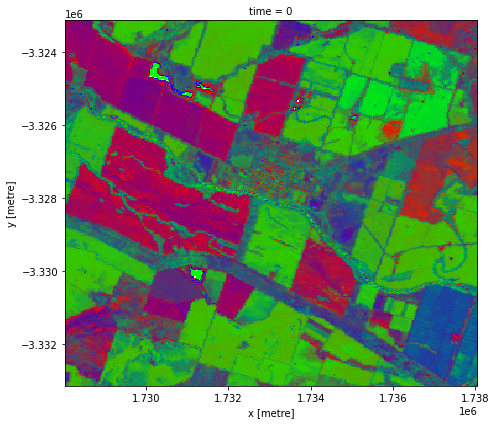

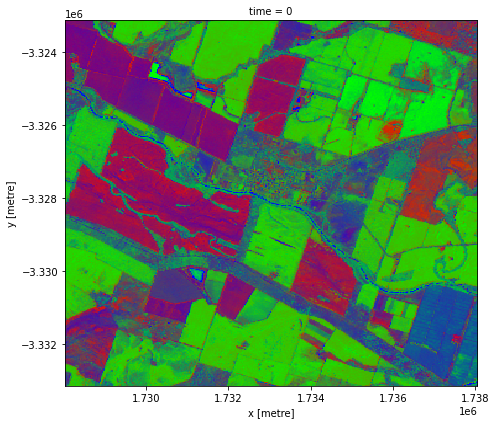

In [15]:
size=6
#L578_r[['nbart_swir_2', 'nbart_nir', 'nbart_red']].to_array().plot.imshow(col='time', col_wrap=5, vmin=0, vmax=5000, size=size)

fc_unmix_L578[['bs', 'pv', 'npv']].to_array().plot.imshow(col='time', vmin=0, vmax=100, size=size)
plt.savefig('../fc_juan/'+date_init+'_L578_false_color.png')
plt.show()


fc_unmix_S2[['bs', 'pv', 'npv']].to_array().plot.imshow(col='time', vmin=0, vmax=100, size=size)
plt.savefig('../fc_juan/'+date_init+'_S2_fc.png')
plt.show()

## show me scatterplots of the results

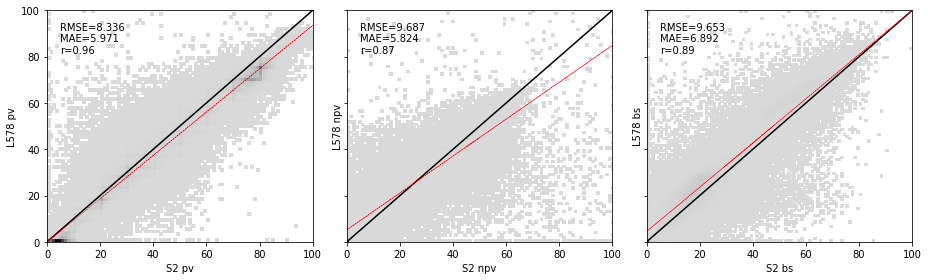

In [16]:
cmap = cm.get_cmap('Greys', 256)
newcmp = ListedColormap(cmap(np.linspace(0.25, 1.0, 256)))
#plot_examples([viridis, newcmp])

fig, axes = plt.subplots(1,3, figsize=(13,4), tight_layout=True, sharey=True, sharex=True) 
fraction = ['pv','npv','bs']
for f in [0,1,2]:
    x=fc_unmix_S2[fraction[f]].values.ravel()  
    y=fc_unmix_L578[fraction[f]].values.ravel()  
    
    # need to remove nans as hist2d doesn't like them
    good_data = np.logical_and(~np.isnan(x), ~np.isnan(y))
    x=x[good_data]
    y=y[good_data]

    axes[f].hist2d(x, y, bins=100, cmap=newcmp, cmin=1)
    #axes[f].scatter(fc_unmix_S2[fraction[f]].values.ravel(), fc_unmix_L578[fraction[f]].values.ravel(), marker='.')
    axes[f].plot([0,110], [0,110], color='k')
    #axes[f].set_xlim(0,0.11)
    #axes[f].set_ylim(0,0.11)
    axes[f].set_ylabel('L578 '+fraction[f])
    axes[f].set_xlabel('S2 '+fraction[f])
    m, b = np.polyfit(x, y, 1)
    axes[f].plot(x, m*x + b, linestyle='dashed', color='r', linewidth=0.5)

    rmse = np.sqrt(mean_squared_error(x,y))
    mae  = mean_absolute_error(x,y)
    r= pearsonr(x,y)[0]
    text = 'RMSE='+str(format(rmse,'.3f'))+ '\n' +'MAE='+str(format(mae,'.3f'))+ '\n' + 'r='+str(format(r,'.2f'))
    # place a text box in upper left in axes coords
    axes[f].text(0.05, 0.95, text, transform=axes[f].transAxes, fontsize=10, verticalalignment='top')    

plt.savefig('../fc_juan/'+date_init+'_S2vsL_fc.png')
plt.show()
